<a href="https://colab.research.google.com/github/SergeiVKalinin/BO_Research/blob/master/Copy_of_DKL_VAE_1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation and Imports

In [ ]:
!pip install git+https://github.com/ziatdinovmax/pyroved.git

In [ ]:
from typing import Tuple, List, Union, Optional, Dict, Type, Callable

import pyro
import pyro.distributions as dist
import pyro.optim as optim
import pyro.infer as infer

import torch
import torch.nn as nn

import numpy as np

from pyroved.models.base import baseVAE
from pyroved.utils import (set_deterministic_mode, get_sampler, transform_coordinates,
                           init_dataloader, generate_latent_grid, plot_img_grid, plot_spect_grid)
from pyroved.nets import fcEncoderNet, fcDecoderNet, sDecoderNet

import matplotlib.pyplot as plt

In [ ]:
#@title Kernels

kernel_fn_type = Callable[[torch.Tensor, torch.Tensor, Dict[str, torch.Tensor], torch.Tensor],  torch.Tensor]

get_device = lambda: 'cuda:0' if torch.cuda.is_available() else 'cpu'

def _sqrt(x, eps=1e-12):
    return torch.sqrt(x + eps)


def add_jitter(x, jitter=1e-6):
    return x + jitter

def square_scaled_distance(X: torch.tensor, Z: torch.Tensor,
                           lengthscale: torch.Tensor = 1.,
                           **kwargs: str
                           ) -> torch.Tensor:

    device = kwargs.get("device", get_device())
    scaled_X = X / lengthscale.to(device)
    scaled_Z = Z / lengthscale.to(device)
    X2 = (scaled_X ** 2).sum(1, keepdims=True)
    Z2 = (scaled_Z ** 2).sum(1, keepdims=True)
    XZ = torch.matmul(scaled_X, scaled_Z.T)
    r2 = X2 - 2 * XZ + Z2.T
    return r2.clip(0)


def RBFKernel(X: torch.Tensor, Z: torch.Tensor,
              params: Dict[str, torch.Tensor],
              noise: int = 0, **kwargs: Union[float, str]
              ) -> torch.Tensor:

    device = kwargs.get("device", get_device())
    r2 = square_scaled_distance(X, Z, params["k_length"])
    k = params["k_scale"] * torch.exp(-0.5 * r2)
    if X.shape == Z.shape:
        k += (add_jitter(noise, **kwargs) * torch.eye(X.shape[0])).to(device)
    return k


def Matern52Kernel(X: torch.Tensor, Z: torch.Tensor,
                   params: Dict[str, torch.Tensor],
                   noise: int = 0, **kwargs: Union[float, str]
                   ) -> torch.Tensor:

    device = kwargs.get("device", get_device())
    r2 = square_scaled_distance(X, Z, params["k_length"])
    r = _sqrt(r2)
    sqrt5_r = 5**0.5 * r
    k = params["k_scale"] * (1 + sqrt5_r + (5/3) * r2) * torch.exp(-sqrt5_r)
    if X.shape == Z.shape:
        k += (add_jitter(noise, **kwargs) * torch.eye(X.shape[0])).to(device)
    return k


def get_kernel(kernel: Union[str, kernel_fn_type] = 'RBF'):
    kernel_book = {
        'RBF': RBFKernel,
        'Matern': Matern52Kernel,
    }
    if isinstance(kernel, str):
        try:
            kernel = kernel_book[kernel]
        except KeyError:
            print('Select one of the currently available kernels:',
                  *kernel_book.keys())
            raise
    return kernel



In [ ]:
#@title VAE-DKL model

class dkiVAE(baseVAE):

    def __init__(self,
                 data_dim: Tuple[int],
                 latent_dim: int,
                 invariances: List[str] = None,
                 hidden_dim_e: List[int] = None,
                 hidden_dim_d: List[int] = None,
                 activation: str = "tanh",
                 sampler_d: str = "bernoulli",
                 sigmoid_d: bool = True,
                 kernel: kernel_fn_type = 'RBF',
                 dkl_scale_factor: int = 1,
                 X: torch.Tensor = None,
                 y: torch.Tensor = None,
                 seed: int = 1,
                 **kwargs: Union[str, float]
                 ) -> None:

        args = (data_dim, invariances)
        super(dkiVAE, self).__init__(*args, **kwargs)
        pyro.clear_param_store()
        set_deterministic_mode(seed)

        self.data_dim = data_dim
        self.kernel = kernel
        self.dkl_scale = dkl_scale_factor

        # Initialize z-Encoder neural network
        self.encoder_z = fcEncoderNet(
            data_dim, latent_dim+self.coord, 0,
            hidden_dim_e, activation, flat=False)

        # Initialize Decoder neural network
        dnet = sDecoderNet if 0 < self.coord < 5 else fcDecoderNet
        self.decoder = dnet(
            data_dim, latent_dim, 0, hidden_dim_d,
            activation, sigmoid_out=sigmoid_d, unflat=False)
        self.sampler_d = get_sampler(sampler_d, **kwargs)

        # Set latent dimensions
        self.z_dim = latent_dim + self.coord

        self.X_train = X
        self.y_train = y

        # Send model parameters to their appropriate devices
        self.to(self.device)

    def set_data(self, X: torch.Tensor, y: torch.Tensor):
        self.X_train = X
        self.y_train = y

    def model(self,
              x: torch.Tensor,
              **kwargs: float) -> None:
        """
        Defines the VAE model p(x|z)p(z)
        """
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        # KLD scale factor (see e.g. https://openreview.net/pdf?id=Sy2fzU9gl)
        beta = kwargs.get("scale_factor", 1.)
        reshape_ = torch.prod(torch.tensor(x.shape[1:])).item()
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            with pyro.poutine.scale(scale=beta):
                z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            if self.coord > 0:  # rotationally- and/or translationaly-invariant mode
                # Split latent variable into parts for rotation
                # and/or translation and image content
                phi, dx, sc, z = self.split_latent(z)
                if 't' in self.invariances:
                    dx = (dx * self.t_prior).unsqueeze(1)
                # transform coordinate grid
                grid = self.grid.expand(x.shape[0], *self.grid.shape)
                x_coord_prime = transform_coordinates(grid, phi, dx, sc)
            # decode the latent code z together with the transformed coordinates (if any)
            dec_args = (x_coord_prime, z) if self.coord else (z,)
            loc = self.decoder(*dec_args)
            # score against actual images ("binary cross-entropy loss")
            pyro.sample(
                "obs", self.sampler_d(loc.view(-1, reshape_)).to_event(1),
                obs=x.view(-1, reshape_))

    def guide(self,
               x: torch.Tensor,
               **kwargs: float) -> None:
        """
        Defines the guide q(z|x)
        """
        # register PyTorch module `encoder_z` with Pyro
        pyro.module("encoder_z", self.encoder_z)
        # KLD scale factor (see e.g. https://openreview.net/pdf?id=Sy2fzU9gl)
        beta = kwargs.get("scale_factor", 1.)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder_z(x)
            # sample the latent code z
            with pyro.poutine.scale(scale=beta):
                pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def split_latent(self, z: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        Split latent variable into parts associated with coordinate transformations
        (rotation and/or transaltion and/or scale) and image content.
        """
        return self._split_latent(z)

    def dkl(self, x: torch.Tensor, y: torch.Tensor) -> None:
        """Defines DKL model"""

        # Encode data using the current state of encoder_z
        z_loc, _ = self.encoder_z(x)
        ### Standard GP on the encoded data ###
        # Sample kernel parameters
        kernel_params = self._sample_kernel_params(self.z_dim - self.coord)
        # Sample noise
        noise = pyro.sample("noise", dist.HalfNormal(1.0))
        # GP's mean function
        f_loc = torch.zeros(z_loc.shape[0]).to(self.device)
        # Compute kernel
        k = get_kernel(self.kernel)(
            z_loc, z_loc,
            kernel_params,
            noise
        )
        # Sample y according to the standard Gaussian process formula
        with pyro.poutine.scale(scale=self.dkl_scale):
            pyro.sample(
                "y",
                dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
                obs=y,
            )

    def _sample_kernel_params(self, dim: int = None) -> Dict[str, torch.Tensor]:
        """
        Sample kernel parameters with weakly-informative log-normal priors
        """
        with pyro.plate('k_param', dim):  # allows using ARD kernel for kernel_dim > 1
            length = pyro.sample("k_length", dist.LogNormal(0.0, 1.0))
        scale = pyro.sample("k_scale", dist.LogNormal(0.0, 1.0))
        kernel_params = {
            "k_length": length, "k_scale": scale}
        return kernel_params

    def encode(self,
               x_new: torch.Tensor,
               **kwargs: int) -> Tuple[torch.Tensor]:
        z = self._encode(x_new, **kwargs)
        z_loc, z_scale = z.split(self.z_dim, 1)
        return z_loc, z_scale

    def decode(self,
               z: torch.Tensor,
               **kwargs: int) -> torch.Tensor:
        z = z.to(self.device)
        loc = self._decode(z, **kwargs)
        return loc

    def get_mvn_posterior(self,
                          z_new: torch.Tensor,
                          noiseless: bool = True,
                          **kwargs
                          ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns predictive mean and covariance at new latent points
        (mean and cov, where cov.diagonal() is 'uncertainty')
        given a single set of GP parameters
        """
        z_new = z_new.to(self.device)
        z_train = self.encode(self.X_train)[0].to(self.device)
        y_train = self.y_train.to(self.device)
        kernel = get_kernel(self.kernel)
        params_store = pyro.get_param_store()
        k_params = {k.split('.')[-1]: v.detach() for (k, v) in params_store.items()
                    if 'k_' in k or 'noise' in k}
        noise = k_params["noise"]
        noise_p = noise * (1 - torch.tensor(noiseless).long())
        # compute kernel matrices for train and test data
        k_pp = kernel(z_new, z_new, k_params, noise_p, **kwargs)
        k_pX = kernel(z_new, z_train, k_params, jitter=0.0)
        k_XX = kernel(z_train, z_train, k_params, noise, **kwargs)
        # compute the predictive covariance and mean
        K_xx_inv = torch.linalg.inv(k_XX)
        cov = k_pp - torch.matmul(k_pX, torch.matmul(K_xx_inv, k_pX.T))
        mean = torch.matmul(k_pX, torch.matmul(K_xx_inv, y_train))
        return mean.cpu(), cov.cpu()

    def dkl_predict(self,
                    X_new: torch.Tensor,
                    noiseless: bool = False,
                    **kwargs
                    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Makes a DKL prediction (input -> encode -> GP -> mean & uncertainty)
        """
        z_new, _ = self.encode(X_new)
        mean, cov = self.get_mvn_posterior(z_new, noiseless, **kwargs)
        return mean, cov.diagonal()

    def manifold2d(self, d: int,
                   plot: bool = True,
                   **kwargs: Union[str, int, float]) -> torch.Tensor:

        z_grid, (grid_x, grid_y) = generate_latent_grid(d, **kwargs)
        loc = self.decode(z_grid, **kwargs)
        if plot:
            if self.ndim == 2:
                loc = loc.reshape(loc.shape[0], *self.data_dim) if loc.ndim < 3 else loc
                plot_img_grid(
                    loc, d,
                    extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
                    **kwargs)
            elif self.ndim == 1:
                plot_spect_grid(loc, d, **kwargs)
        return loc


In [ ]:
#@title VAE-DKL Trainer

class JointModelTrainer:

    def __init__(self,
                model: Type[torch.nn.Module],
                lr1: float = 1e-4,
                lr2: float = 1e-2,
                optimizer2: Type[pyro.optim.PyroOptim] = None,
                loss_vae: Type[infer.ELBO] = None,
                loss_dkl: Type[infer.ELBO] = None,
                seed: int = 1,
                **kwargs: Union[str, float]
                ) -> None:

        pyro.clear_param_store()
        set_deterministic_mode(seed)
        self.device = kwargs.get(
            "device", 'cuda' if torch.cuda.is_available() else 'cpu')

        optimizer1 = optim.Adam({"lr": lr1})
        optimizer2 = optim.Adam({"lr": lr2})

        loss_vae = infer.Trace_ELBO() if loss_vae is None else loss1
        loss_dkl = infer.Trace_ELBO() if loss_dkl is None else loss2

        self.vae_svi = infer.SVI(
            model.model, model.guide, optimizer1, loss=loss_vae)
        self.dkl_svi = infer.SVI(
            model.dkl, infer.autoguide.AutoDelta(model.dkl),
            optimizer2, loss=loss_dkl)

        self.loss_history = {"training_loss": [], "test_loss": []}
        self.current_epoch = 0
        self.model = model

    def train(self,
              train_loader: Type[torch.utils.data.DataLoader],
              train_vae: bool = True,
              **kwargs: float) -> float:
        """
        Trains a single epoch
        """
        # initialize loss accumulator
        vae_epoch_loss = 0.
        if train_vae:
            # do a training epoch over each mini-batch returned by the data loader
            for data in train_loader:
                x, _ = data
                vae_loss = self.vae_svi.step(x.to(self.device), **kwargs)
                # accumulate loss
                vae_epoch_loss += vae_loss
        vae_epoch_loss /= len(train_loader.dataset)
        # Pass entire data through DKL (exact-gp regime)
        xf, yf = train_loader.dataset.tensors
        dkl_loss = self.dkl_svi.step(
            xf.to(self.device), yf.to(self.device), **kwargs)
        #print(vae_epoch_loss, dkl_loss)
        return vae_epoch_loss + dkl_loss

    def step(self,
             train_loader: Type[torch.utils.data.DataLoader],
             train_vae: bool = True,
             **kwargs: float) -> None:
        """
        Single training and (optionally) test step
        Args:
            train_loader:
                Pytorch’s dataloader object with training data
            train_vae:
                Train variational autoencoder at this step
        """
        if self.model.X_train is None or self.model.y_train is None:
            self.model.set_data(*train_loader.dataset.tensors)
        train_loss = self.train(train_loader, train_vae, **kwargs)
        self.loss_history["training_loss"].append(train_loss)
        self.current_epoch += 1

    def print_statistics(self) -> None:
        """
        Prints training and test (if any) losses for current epoch
        """
        e = self.current_epoch
        template = 'Epoch: {} Training loss: {:.4f}'
        print(template.format(e, self.loss_history["training_loss"][-1]))


### Prepare data

In [ ]:
!wget "https://www.dropbox.com/s/zmdk2x6odus6tq7/dummy_data_plasmons.npz"

--2023-02-12 18:41:34--  https://www.dropbox.com/s/zmdk2x6odus6tq7/dummy_data_plasmons.npz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.84.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.84.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmdk2x6odus6tq7/dummy_data_plasmons.npz [following]
--2023-02-12 18:41:35--  https://www.dropbox.com/s/raw/zmdk2x6odus6tq7/dummy_data_plasmons.npz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc17feb7f6f7473d55dbc2da116b.dl.dropboxusercontent.com/cd/0/inline/B2Vo5wNaX2mevmyITg6J9yZWQdYgCxGPrrFF60gPG2BtwtSCv06msv5_b7x6RAGe6HZG5zui9j1j_bHX314Fj3HJrftsxzb5_TEcuEHeiFTWmwAPJgYMN_COgfAsciYxEuPfKZ41SZ_8y7gb6wrwTiLXxy4gd7WicfTpQMEXEgqm4Q/file# [following]
--2023-02-12 18:41:36--  https://uc17feb7f6f7473d55dbc2da116b.dl.dropboxusercontent.com/cd/0/inline/B2Vo5wNaX2mevmyITg6J9yZWQdYgCxGPrrFF60gPG2Bt

In [ ]:
data = np.load("dummy_data_plasmons.npz")
features_all = data["features"]
peaks_all = data["targets"]
indices_all = data["indices"]

In [ ]:
n, d1, d2 = features_all.shape
features_all = features_all.reshape(n, d1*d2)
peaks_all = peaks_all

features_all = torch.from_numpy(features_all).float()
peaks_all = torch.from_numpy(peaks_all).float()

dataloader = init_dataloader(features_all, peaks_all, batch_size=100)

Plot the target values for each feature (image patch) coordinate:

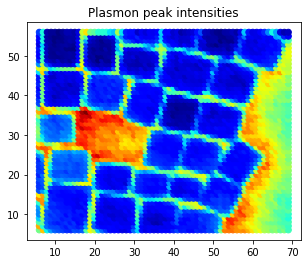

In [ ]:
_, ax = plt.subplots()
ax.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet')
ax.set_title('Plasmon peak intensities')
ax.set_aspect('equal')

### Train VAE-DKL model

Epoch: 1 Training loss: 55990.5258
Epoch: 2 Training loss: 55510.7767
Epoch: 3 Training loss: 55111.5383
Epoch: 4 Training loss: 54775.4293
Epoch: 5 Training loss: 54463.3851
Epoch: 6 Training loss: 54116.1850
Epoch: 7 Training loss: 53777.4372
Epoch: 8 Training loss: 53415.5084
Epoch: 9 Training loss: 53057.3549
Epoch: 10 Training loss: 52699.7987
Epoch: 11 Training loss: 52361.3779
Epoch: 12 Training loss: 52020.0775
Epoch: 13 Training loss: 51687.5074
Epoch: 14 Training loss: 51341.3537
Epoch: 15 Training loss: 51012.7136
Epoch: 16 Training loss: 50678.3466
Epoch: 17 Training loss: 50352.7775
Epoch: 18 Training loss: 50022.3604
Epoch: 19 Training loss: 49695.8694
Epoch: 20 Training loss: 49360.6742
Epoch: 21 Training loss: 49036.3000
Epoch: 22 Training loss: 48705.2863
Epoch: 23 Training loss: 48382.6724
Epoch: 24 Training loss: 48047.3578
Epoch: 25 Training loss: 47722.5400
Epoch: 26 Training loss: 47398.4215
Epoch: 27 Training loss: 47080.6820
Epoch: 28 Training loss: 46747.0607
E

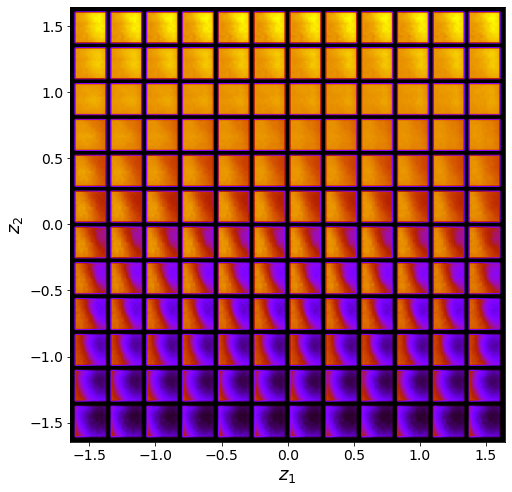

Epoch: 51 Training loss: 39249.5232
Epoch: 52 Training loss: 38921.0778
Epoch: 53 Training loss: 38611.1388
Epoch: 54 Training loss: 38278.1431
Epoch: 55 Training loss: 37969.4845
Epoch: 56 Training loss: 37623.4293
Epoch: 57 Training loss: 37306.0804
Epoch: 58 Training loss: 36966.1537
Epoch: 59 Training loss: 36651.7453
Epoch: 60 Training loss: 36332.4795
Epoch: 61 Training loss: 36034.6018
Epoch: 62 Training loss: 35675.0368
Epoch: 63 Training loss: 35364.4745
Epoch: 64 Training loss: 35017.6212
Epoch: 65 Training loss: 34722.1804
Epoch: 66 Training loss: 34363.8705
Epoch: 67 Training loss: 34070.8374
Epoch: 68 Training loss: 33714.1701
Epoch: 69 Training loss: 33433.5522
Epoch: 70 Training loss: 33066.2180
Epoch: 71 Training loss: 32774.1500
Epoch: 72 Training loss: 32409.5664
Epoch: 73 Training loss: 32107.2874
Epoch: 74 Training loss: 31764.8639
Epoch: 75 Training loss: 31469.5578
Epoch: 76 Training loss: 31113.6034
Epoch: 77 Training loss: 30822.6877
Epoch: 78 Training loss: 304

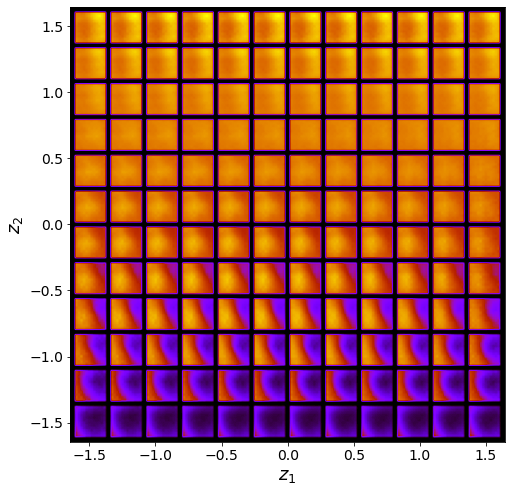

Epoch: 101 Training loss: 23016.6140
Epoch: 102 Training loss: 22674.9315
Epoch: 103 Training loss: 22365.6335
Epoch: 104 Training loss: 22035.2423
Epoch: 105 Training loss: 21738.3497
Epoch: 106 Training loss: 21384.9196
Epoch: 107 Training loss: 21085.4485
Epoch: 108 Training loss: 20725.6193
Epoch: 109 Training loss: 20424.1440
Epoch: 110 Training loss: 20077.8329
Epoch: 111 Training loss: 19776.2520
Epoch: 112 Training loss: 19442.7064
Epoch: 113 Training loss: 19147.7318
Epoch: 114 Training loss: 18786.8166
Epoch: 115 Training loss: 18488.9388
Epoch: 116 Training loss: 18144.9650
Epoch: 117 Training loss: 17853.3583
Epoch: 118 Training loss: 17500.9933
Epoch: 119 Training loss: 17193.4343
Epoch: 120 Training loss: 16858.1753
Epoch: 121 Training loss: 16582.4205
Epoch: 122 Training loss: 16220.7712
Epoch: 123 Training loss: 15902.6929
Epoch: 124 Training loss: 15552.2186
Epoch: 125 Training loss: 15236.2328
Epoch: 126 Training loss: 14900.8342
Epoch: 127 Training loss: 14583.0543
E

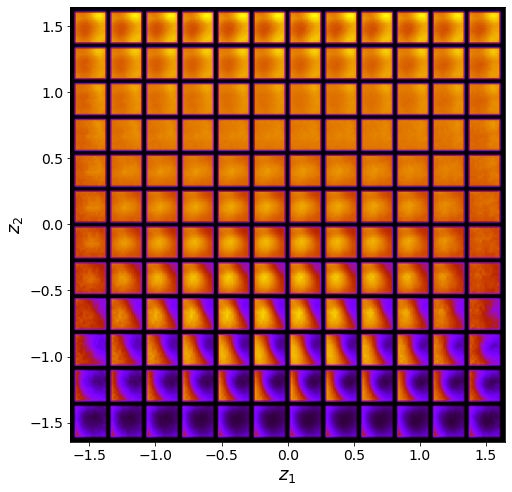

Epoch: 151 Training loss: 6905.1113
Epoch: 152 Training loss: 6603.5786
Epoch: 153 Training loss: 6295.3593
Epoch: 154 Training loss: 5927.3271
Epoch: 155 Training loss: 5586.0990
Epoch: 156 Training loss: 5249.1411
Epoch: 157 Training loss: 4945.9619
Epoch: 158 Training loss: 4614.4849
Epoch: 159 Training loss: 4306.6331
Epoch: 160 Training loss: 3978.8410
Epoch: 161 Training loss: 3670.9002
Epoch: 162 Training loss: 3327.3843
Epoch: 163 Training loss: 3053.4904
Epoch: 164 Training loss: 2719.9108
Epoch: 165 Training loss: 2450.2888
Epoch: 166 Training loss: 2134.0758
Epoch: 167 Training loss: 1839.4375
Epoch: 168 Training loss: 1462.1803
Epoch: 169 Training loss: 1150.2542
Epoch: 170 Training loss: 800.8206
Epoch: 171 Training loss: 473.1058
Epoch: 172 Training loss: 151.6923
Epoch: 173 Training loss: -162.3822
Epoch: 174 Training loss: -496.3768
Epoch: 175 Training loss: -814.6690
Epoch: 176 Training loss: -1119.8690
Epoch: 177 Training loss: -1420.3847
Epoch: 178 Training loss: -17

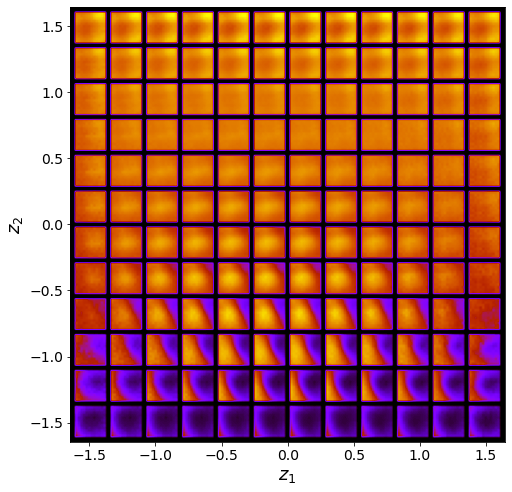

Epoch: 201 Training loss: -9121.7061
Epoch: 202 Training loss: -9443.5166
Epoch: 203 Training loss: -9742.8650
Epoch: 204 Training loss: -10038.6459
Epoch: 205 Training loss: -10247.9246
Epoch: 206 Training loss: -10425.1091
Epoch: 207 Training loss: -10660.6770
Epoch: 208 Training loss: -11084.7158
Epoch: 209 Training loss: -11529.6513
Epoch: 210 Training loss: -11932.6616
Epoch: 211 Training loss: -12271.5706
Epoch: 212 Training loss: -12591.4766
Epoch: 213 Training loss: -12919.2322
Epoch: 214 Training loss: -13211.1237
Epoch: 215 Training loss: -13522.8786
Epoch: 216 Training loss: -13800.0815
Epoch: 217 Training loss: -14124.4881
Epoch: 218 Training loss: -14379.4995
Epoch: 219 Training loss: -14670.4086
Epoch: 220 Training loss: -14959.9412
Epoch: 221 Training loss: -15309.6972
Epoch: 222 Training loss: -15632.3798
Epoch: 223 Training loss: -15953.5704
Epoch: 224 Training loss: -16300.1817
Epoch: 225 Training loss: -16596.8089
Epoch: 226 Training loss: -16920.8095
Epoch: 227 Trai

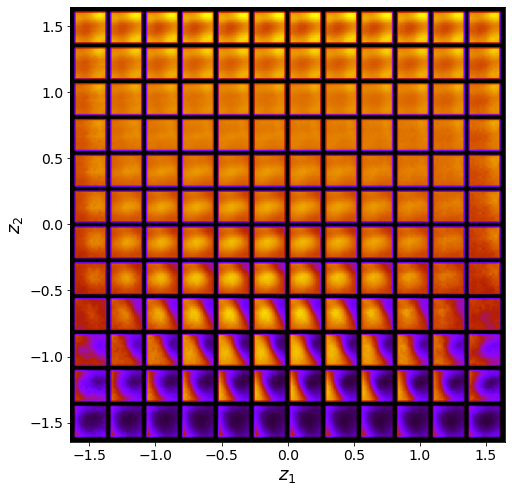

Epoch: 251 Training loss: -24802.6633
Epoch: 252 Training loss: -25125.0813
Epoch: 253 Training loss: -25443.3595
Epoch: 254 Training loss: -25748.8152
Epoch: 255 Training loss: -26057.9557
Epoch: 256 Training loss: -26334.4909
Epoch: 257 Training loss: -26585.3904
Epoch: 258 Training loss: -26765.0631
Epoch: 259 Training loss: -26976.5008
Epoch: 260 Training loss: -27131.2987
Epoch: 261 Training loss: -27477.9347
Epoch: 262 Training loss: -27939.2872
Epoch: 263 Training loss: -28342.1299
Epoch: 264 Training loss: -28735.8060
Epoch: 265 Training loss: -29023.7811
Epoch: 266 Training loss: -29389.0746
Epoch: 267 Training loss: -29677.4549
Epoch: 268 Training loss: -30035.3239
Epoch: 269 Training loss: -30301.2530
Epoch: 270 Training loss: -30624.9323
Epoch: 271 Training loss: -30875.6804
Epoch: 272 Training loss: -31183.6639
Epoch: 273 Training loss: -31401.6891
Epoch: 274 Training loss: -31726.9415
Epoch: 275 Training loss: -31976.8365
Epoch: 276 Training loss: -32285.8479
Epoch: 277 T

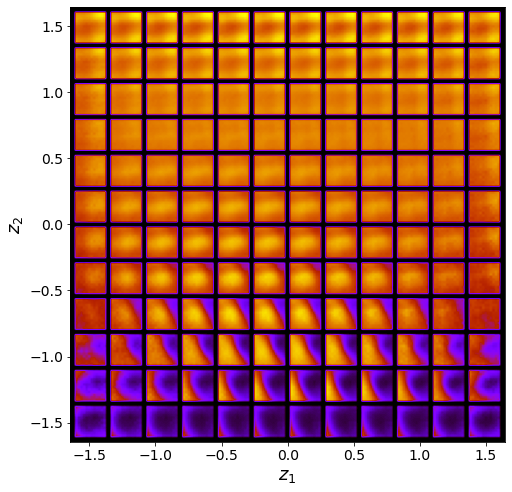

Epoch: 301 Training loss: -39525.1988
Epoch: 302 Training loss: -39991.3301
Epoch: 303 Training loss: -40498.1117
Epoch: 304 Training loss: -40951.2869
Epoch: 305 Training loss: -41268.4000
Epoch: 306 Training loss: -41599.8284
Epoch: 307 Training loss: -41898.7211
Epoch: 308 Training loss: -42200.5145
Epoch: 309 Training loss: -42430.6328
Epoch: 310 Training loss: -42665.6169
Epoch: 311 Training loss: -42764.6442
Epoch: 312 Training loss: -42964.7213
Epoch: 313 Training loss: -43168.3625
Epoch: 314 Training loss: -43604.1547
Epoch: 315 Training loss: -43958.3286
Epoch: 316 Training loss: -44309.7205
Epoch: 317 Training loss: -44613.8071
Epoch: 318 Training loss: -44849.8937
Epoch: 319 Training loss: -45235.5513
Epoch: 320 Training loss: -45527.8922
Epoch: 321 Training loss: -45925.6932
Epoch: 322 Training loss: -46223.3734
Epoch: 323 Training loss: -46593.7826
Epoch: 324 Training loss: -46863.0370
Epoch: 325 Training loss: -47171.0505
Epoch: 326 Training loss: -47363.2976
Epoch: 327 T

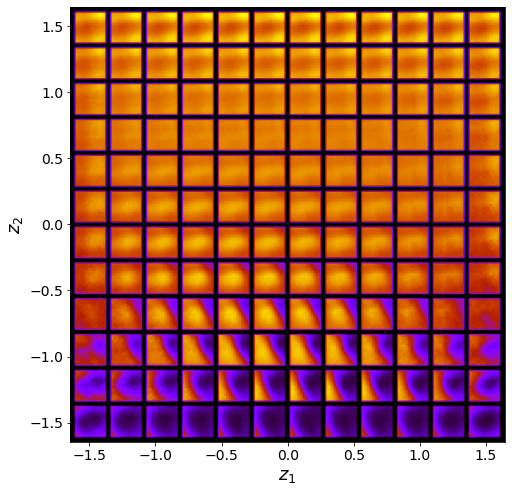

Epoch: 351 Training loss: -54331.4828
Epoch: 352 Training loss: -54647.4953
Epoch: 353 Training loss: -54948.2306
Epoch: 354 Training loss: -55378.5077
Epoch: 355 Training loss: -55732.4438
Epoch: 356 Training loss: -56095.8856
Epoch: 357 Training loss: -56380.2830
Epoch: 358 Training loss: -56658.6194
Epoch: 359 Training loss: -56889.3220
Epoch: 360 Training loss: -57006.5526
Epoch: 361 Training loss: -57205.3375
Epoch: 362 Training loss: -57191.6446
Epoch: 363 Training loss: -57502.5996
Epoch: 364 Training loss: -57821.0677
Epoch: 365 Training loss: -58432.0312
Epoch: 366 Training loss: -58764.8510
Epoch: 367 Training loss: -59220.7128
Epoch: 368 Training loss: -59511.6530
Epoch: 369 Training loss: -59826.8281
Epoch: 370 Training loss: -60025.3704
Epoch: 371 Training loss: -60300.2907
Epoch: 372 Training loss: -60340.0288
Epoch: 373 Training loss: -60679.9744
Epoch: 374 Training loss: -60695.1788
Epoch: 375 Training loss: -61133.1236
Epoch: 376 Training loss: -61221.1994
Epoch: 377 T

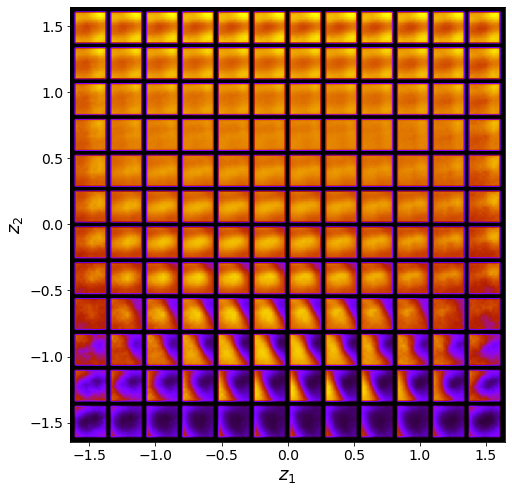

Epoch: 401 Training loss: -67873.7675
Epoch: 402 Training loss: -67149.8047
Epoch: 403 Training loss: -67903.7934
Epoch: 404 Training loss: -68588.6142
Epoch: 405 Training loss: -69455.4927
Epoch: 406 Training loss: -69830.4978
Epoch: 407 Training loss: -70134.0281
Epoch: 408 Training loss: -70402.4456
Epoch: 409 Training loss: -70681.7823
Epoch: 410 Training loss: -70878.1724
Epoch: 411 Training loss: -71130.7685
Epoch: 412 Training loss: -71133.8062
Epoch: 413 Training loss: -71404.3110
Epoch: 414 Training loss: -71078.7056
Epoch: 415 Training loss: -71828.1285
Epoch: 416 Training loss: -71954.4234
Epoch: 417 Training loss: -72483.7842
Epoch: 418 Training loss: -72641.5868
Epoch: 419 Training loss: -72997.6687
Epoch: 420 Training loss: -73136.7208
Epoch: 421 Training loss: -73426.6754
Epoch: 422 Training loss: -73504.6887
Epoch: 423 Training loss: -73673.8169
Epoch: 424 Training loss: -73822.8570
Epoch: 425 Training loss: -73906.5680
Epoch: 426 Training loss: -74547.0265
Epoch: 427 T

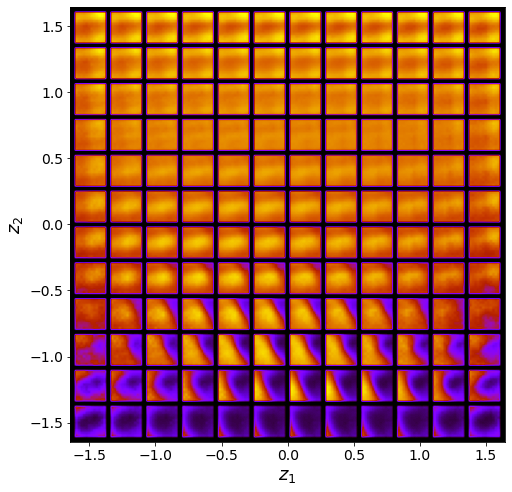

Epoch: 451 Training loss: -80120.0672
Epoch: 452 Training loss: -80419.1770
Epoch: 453 Training loss: -80466.1318
Epoch: 454 Training loss: -81011.1262
Epoch: 455 Training loss: -81464.2228
Epoch: 456 Training loss: -81741.0662
Epoch: 457 Training loss: -82133.3996
Epoch: 458 Training loss: -82205.3598
Epoch: 459 Training loss: -82592.5657
Epoch: 460 Training loss: -82397.9380
Epoch: 461 Training loss: -82980.9764
Epoch: 462 Training loss: -82717.5143
Epoch: 463 Training loss: -83535.2096
Epoch: 464 Training loss: -83515.1386
Epoch: 465 Training loss: -84015.9648
Epoch: 466 Training loss: -83818.3923
Epoch: 467 Training loss: -84579.5137
Epoch: 468 Training loss: -84529.3256
Epoch: 469 Training loss: -85026.9710
Epoch: 470 Training loss: -84783.7386
Epoch: 471 Training loss: -85373.4053
Epoch: 472 Training loss: -85168.9382
Epoch: 473 Training loss: -85926.8837
Epoch: 474 Training loss: -85920.0823
Epoch: 475 Training loss: -86248.8597
Epoch: 476 Training loss: -85912.9354
Epoch: 477 T

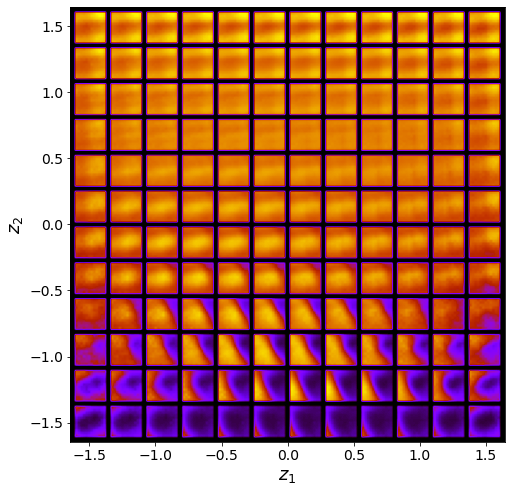

Epoch: 501 Training loss: -90972.3508
Epoch: 502 Training loss: -91955.9906
Epoch: 503 Training loss: -91701.4391
Epoch: 504 Training loss: -92301.7372
Epoch: 505 Training loss: -91896.4271
Epoch: 506 Training loss: -92684.8977
Epoch: 507 Training loss: -92445.9892
Epoch: 508 Training loss: -92742.8080
Epoch: 509 Training loss: -91483.1113
Epoch: 510 Training loss: -92841.3816
Epoch: 511 Training loss: -91987.3391
Epoch: 512 Training loss: -92187.0138
Epoch: 513 Training loss: -92391.5617
Epoch: 514 Training loss: -93546.7145
Epoch: 515 Training loss: -93907.6912
Epoch: 516 Training loss: -94433.7392
Epoch: 517 Training loss: -94049.9723
Epoch: 518 Training loss: -94724.6576
Epoch: 519 Training loss: -94128.5956
Epoch: 520 Training loss: -95157.9180
Epoch: 521 Training loss: -95054.1499
Epoch: 522 Training loss: -95724.5441
Epoch: 523 Training loss: -95525.2176
Epoch: 524 Training loss: -96007.8351
Epoch: 525 Training loss: -95609.3273
Epoch: 526 Training loss: -96470.6604
Epoch: 527 T

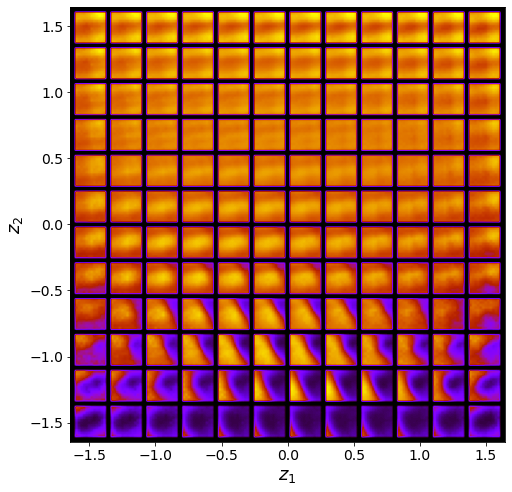

Epoch: 551 Training loss: -99682.5295
Epoch: 552 Training loss: -100851.1444
Epoch: 553 Training loss: -100230.8934
Epoch: 554 Training loss: -100669.9616
Epoch: 555 Training loss: -99390.3968
Epoch: 556 Training loss: -100563.0669
Epoch: 557 Training loss: -100599.3392
Epoch: 558 Training loss: -101269.3639
Epoch: 559 Training loss: -101300.0493
Epoch: 560 Training loss: -101856.7227
Epoch: 561 Training loss: -101508.2633
Epoch: 562 Training loss: -102092.9216
Epoch: 563 Training loss: -101324.8185
Epoch: 564 Training loss: -102472.1532
Epoch: 565 Training loss: -101983.3050
Epoch: 566 Training loss: -102385.5984
Epoch: 567 Training loss: -101242.8373
Epoch: 568 Training loss: -101567.1515
Epoch: 569 Training loss: -101002.0506
Epoch: 570 Training loss: -100290.2471
Epoch: 571 Training loss: -103314.7888
Epoch: 572 Training loss: -103803.3697
Epoch: 573 Training loss: -104108.0400
Epoch: 574 Training loss: -104112.6611
Epoch: 575 Training loss: -104165.2210
Epoch: 576 Training loss: -

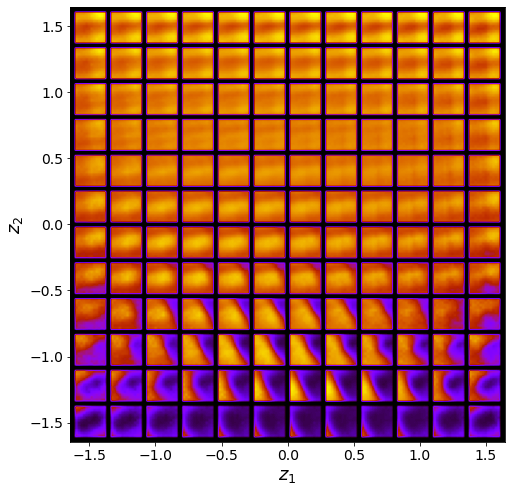

Epoch: 601 Training loss: -105590.4740
Epoch: 602 Training loss: -105700.0511
Epoch: 603 Training loss: -105658.3037
Epoch: 604 Training loss: -107524.4995
Epoch: 605 Training loss: -107446.5610
Epoch: 606 Training loss: -107720.5665
Epoch: 607 Training loss: -107009.2493
Epoch: 608 Training loss: -107640.9896
Epoch: 609 Training loss: -107025.5583
Epoch: 610 Training loss: -107744.5259
Epoch: 611 Training loss: -107540.6947
Epoch: 612 Training loss: -107749.9945
Epoch: 613 Training loss: -107398.8527
Epoch: 614 Training loss: -105014.4750
Epoch: 615 Training loss: -107562.1312
Epoch: 616 Training loss: -106246.2167
Epoch: 617 Training loss: -109318.4573
Epoch: 618 Training loss: -109722.6249
Epoch: 619 Training loss: -109860.0982
Epoch: 620 Training loss: -109072.9946
Epoch: 621 Training loss: -109547.1200
Epoch: 622 Training loss: -107619.3486
Epoch: 623 Training loss: -110230.0139
Epoch: 624 Training loss: -110316.3953
Epoch: 625 Training loss: -110166.4252
Epoch: 626 Training loss:

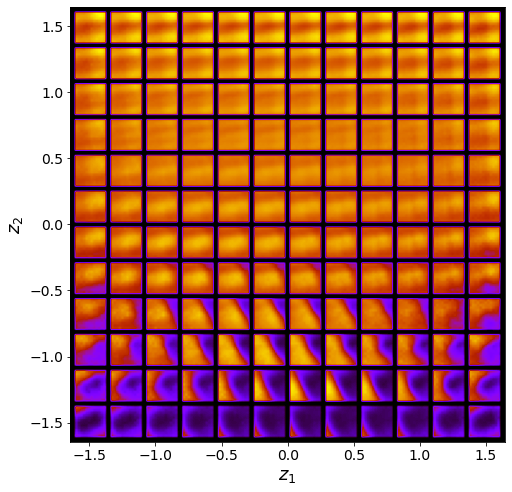

Epoch: 651 Training loss: -112701.2351
Epoch: 652 Training loss: -111194.9658
Epoch: 653 Training loss: -112634.3617
Epoch: 654 Training loss: -111027.8930
Epoch: 655 Training loss: -112473.8748
Epoch: 656 Training loss: -111121.0585
Epoch: 657 Training loss: -112952.3506
Epoch: 658 Training loss: -112294.5527
Epoch: 659 Training loss: -112962.4178
Epoch: 660 Training loss: -111633.7979
Epoch: 661 Training loss: -113721.4328
Epoch: 662 Training loss: -113347.9029
Epoch: 663 Training loss: -113383.9189
Epoch: 664 Training loss: -111323.0637
Epoch: 665 Training loss: -114274.6883
Epoch: 666 Training loss: -114325.2773
Epoch: 667 Training loss: -113528.9138
Epoch: 668 Training loss: -110224.9489
Epoch: 669 Training loss: -113157.4094
Epoch: 670 Training loss: -112613.8069
Epoch: 671 Training loss: -111602.7285
Epoch: 672 Training loss: -108436.9623
Epoch: 673 Training loss: -111894.0924
Epoch: 674 Training loss: -110268.6936
Epoch: 675 Training loss: -110032.4824
Epoch: 676 Training loss:

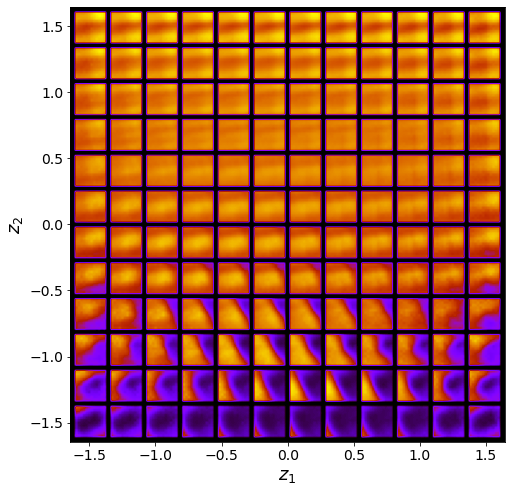

Epoch: 701 Training loss: -116523.8646
Epoch: 702 Training loss: -115790.1532
Epoch: 703 Training loss: -115330.3027
Epoch: 704 Training loss: -111668.3237
Epoch: 705 Training loss: -115730.5609
Epoch: 706 Training loss: -115381.7578
Epoch: 707 Training loss: -113398.1851
Epoch: 708 Training loss: -112628.4315
Epoch: 709 Training loss: -112001.2762
Epoch: 710 Training loss: -114818.3549
Epoch: 711 Training loss: -114812.7620
Epoch: 712 Training loss: -112629.8369
Epoch: 713 Training loss: -114931.8071
Epoch: 714 Training loss: -113043.5867
Epoch: 715 Training loss: -116412.3684
Epoch: 716 Training loss: -115688.9808
Epoch: 717 Training loss: -116828.7676
Epoch: 718 Training loss: -115398.2580
Epoch: 719 Training loss: -117069.3762
Epoch: 720 Training loss: -115049.7284
Epoch: 721 Training loss: -117234.8861
Epoch: 722 Training loss: -115016.5863
Epoch: 723 Training loss: -117397.1605
Epoch: 724 Training loss: -115697.2631
Epoch: 725 Training loss: -117336.3224
Epoch: 726 Training loss:

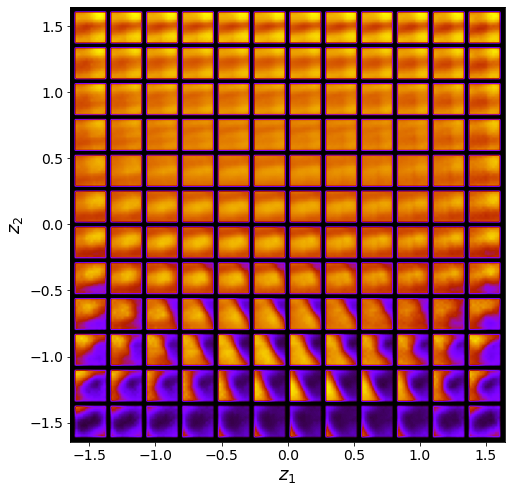

Epoch: 751 Training loss: -115167.4427
Epoch: 752 Training loss: -117309.8892
Epoch: 753 Training loss: -116923.8715
Epoch: 754 Training loss: -118247.1216
Epoch: 755 Training loss: -117023.4677
Epoch: 756 Training loss: -118828.3680
Epoch: 757 Training loss: -116972.8788
Epoch: 758 Training loss: -119082.0518
Epoch: 759 Training loss: -116940.7124
Epoch: 760 Training loss: -119414.7071
Epoch: 761 Training loss: -117639.0435
Epoch: 762 Training loss: -119409.4398
Epoch: 763 Training loss: -117387.2240
Epoch: 764 Training loss: -119827.7925
Epoch: 765 Training loss: -118608.3282
Epoch: 766 Training loss: -119373.3203
Epoch: 767 Training loss: -116797.7197
Epoch: 768 Training loss: -120380.3617
Epoch: 769 Training loss: -120374.8326
Epoch: 770 Training loss: -119838.6776
Epoch: 771 Training loss: -117299.5946
Epoch: 772 Training loss: -119970.3236
Epoch: 773 Training loss: -118687.7663
Epoch: 774 Training loss: -119225.9809
Epoch: 775 Training loss: -117127.0247
Epoch: 776 Training loss:

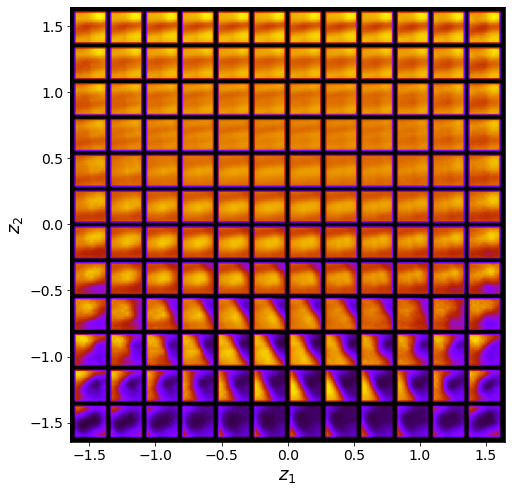

Epoch: 801 Training loss: -115732.0385
Epoch: 802 Training loss: -120664.1860
Epoch: 803 Training loss: -119844.6085
Epoch: 804 Training loss: -120028.8874
Epoch: 805 Training loss: -117476.6229
Epoch: 806 Training loss: -120130.0520
Epoch: 807 Training loss: -118822.4987
Epoch: 808 Training loss: -120182.4944
Epoch: 809 Training loss: -119315.9857
Epoch: 810 Training loss: -119143.5378
Epoch: 811 Training loss: -119883.5574
Epoch: 812 Training loss: -117855.1814
Epoch: 813 Training loss: -121449.0711
Epoch: 814 Training loss: -119583.7929
Epoch: 815 Training loss: -121068.5175
Epoch: 816 Training loss: -117344.2203
Epoch: 817 Training loss: -121987.1113
Epoch: 818 Training loss: -121592.1424
Epoch: 819 Training loss: -120532.2540
Epoch: 820 Training loss: -116321.8723
Epoch: 821 Training loss: -122104.5612
Epoch: 822 Training loss: -122407.1868
Epoch: 823 Training loss: -121485.9201
Epoch: 824 Training loss: -119429.8747
Epoch: 825 Training loss: -118018.2523
Epoch: 826 Training loss:

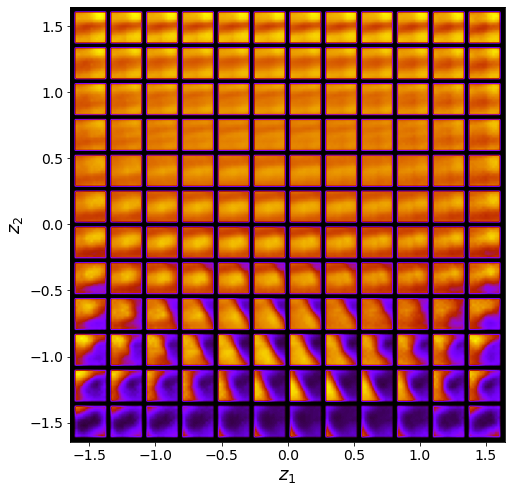

Epoch: 851 Training loss: -121103.1654
Epoch: 852 Training loss: -121503.7470
Epoch: 853 Training loss: -120403.1785
Epoch: 854 Training loss: -121349.3600
Epoch: 855 Training loss: -121698.5541
Epoch: 856 Training loss: -121162.7313
Epoch: 857 Training loss: -122387.9674
Epoch: 858 Training loss: -119962.1211
Epoch: 859 Training loss: -122474.2560
Epoch: 860 Training loss: -119270.9355
Epoch: 861 Training loss: -122733.0944
Epoch: 862 Training loss: -121190.9864
Epoch: 863 Training loss: -122714.4520
Epoch: 864 Training loss: -120851.5501
Epoch: 865 Training loss: -123698.8341
Epoch: 866 Training loss: -122645.3087
Epoch: 867 Training loss: -123148.2937
Epoch: 868 Training loss: -119615.5823
Epoch: 869 Training loss: -122770.5022
Epoch: 870 Training loss: -119824.0846
Epoch: 871 Training loss: -119580.7604
Epoch: 872 Training loss: -116197.2639
Epoch: 873 Training loss: -123006.9948
Epoch: 874 Training loss: -122479.2085
Epoch: 875 Training loss: -121455.8672
Epoch: 876 Training loss:

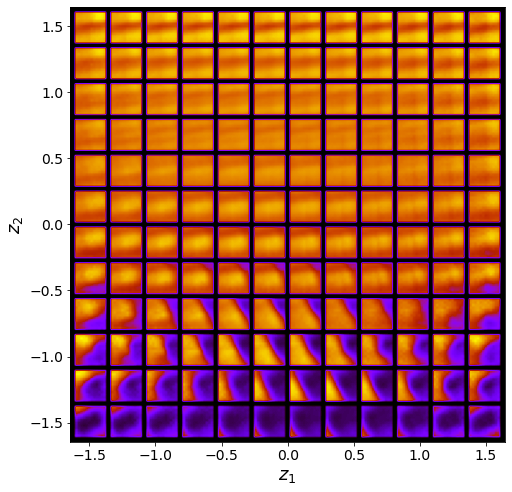

Epoch: 901 Training loss: -117409.6133
Epoch: 902 Training loss: -123927.5811
Epoch: 903 Training loss: -123415.9006
Epoch: 904 Training loss: -123823.2932
Epoch: 905 Training loss: -120467.9664
Epoch: 906 Training loss: -124278.3359
Epoch: 907 Training loss: -122079.5744
Epoch: 908 Training loss: -123962.3718
Epoch: 909 Training loss: -121169.6133
Epoch: 910 Training loss: -124264.4117
Epoch: 911 Training loss: -122740.9738
Epoch: 912 Training loss: -123639.1500
Epoch: 913 Training loss: -122267.5122
Epoch: 914 Training loss: -123665.7160
Epoch: 915 Training loss: -123425.1487
Epoch: 916 Training loss: -123829.8521
Epoch: 917 Training loss: -124055.7664
Epoch: 918 Training loss: -123217.6642
Epoch: 919 Training loss: -123961.3409
Epoch: 920 Training loss: -120683.7456
Epoch: 921 Training loss: -123795.5276
Epoch: 922 Training loss: -120449.4528
Epoch: 923 Training loss: -123350.9132
Epoch: 924 Training loss: -122449.1102
Epoch: 925 Training loss: -124772.7675
Epoch: 926 Training loss:

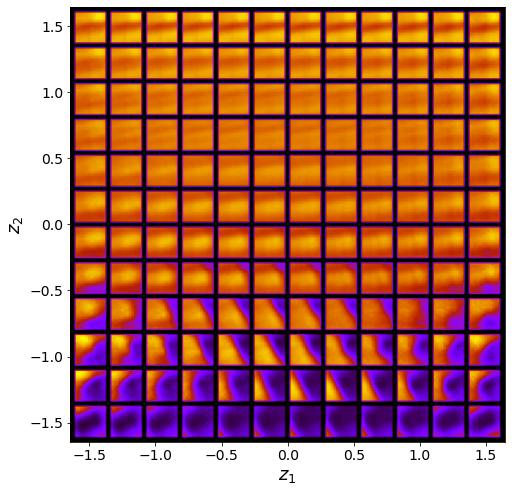

Epoch: 951 Training loss: -123249.3079
Epoch: 952 Training loss: -125984.1281
Epoch: 953 Training loss: -123829.3167
Epoch: 954 Training loss: -125663.1044
Epoch: 955 Training loss: -123394.6601
Epoch: 956 Training loss: -125962.1592
Epoch: 957 Training loss: -124609.8215
Epoch: 958 Training loss: -125887.3645
Epoch: 959 Training loss: -124016.8356
Epoch: 960 Training loss: -126397.2131
Epoch: 961 Training loss: -124891.1141
Epoch: 962 Training loss: -126243.7181
Epoch: 963 Training loss: -124362.5396
Epoch: 964 Training loss: -126304.5501
Epoch: 965 Training loss: -124923.3258
Epoch: 966 Training loss: -125506.7677
Epoch: 967 Training loss: -123948.1401
Epoch: 968 Training loss: -123408.1422
Epoch: 969 Training loss: -122525.6517
Epoch: 970 Training loss: -119053.3890
Epoch: 971 Training loss: -125079.7944
Epoch: 972 Training loss: -123856.9459
Epoch: 973 Training loss: -125961.4245
Epoch: 974 Training loss: -124943.8512
Epoch: 975 Training loss: -125957.3199
Epoch: 976 Training loss:

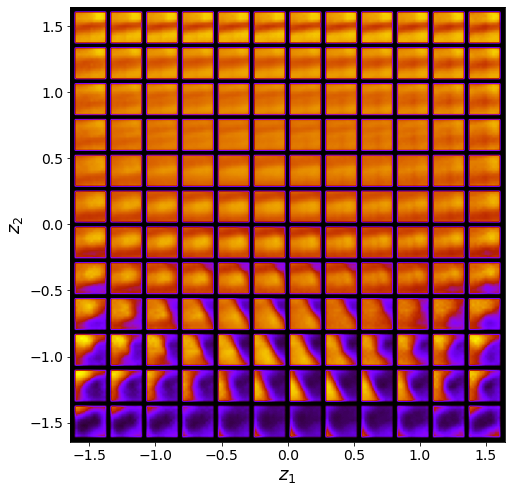

In [ ]:
data_dim = (12, 12)

model = dkiVAE(data_dim, 2, dkl_scale_factor=20)
trainer = JointModelTrainer(model)

for e in range(1000):
    #train_vae = 0 if e < 200 else 1  # we can start training VAE e.g. after 200 epochs
    trainer.step(dataloader, train_vae=True)
    trainer.print_statistics()
    if (e+1) % 50 == 0:
        model.manifold2d(d=12)

Encode data with trained encoder (that was shared between VAE and DKL during the training):

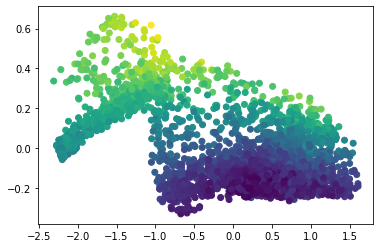

In [ ]:
z_loc, _ = model.encode(features_all)

plt.scatter(z_loc[:, -2], z_loc[:, -1], c=peaks_all)

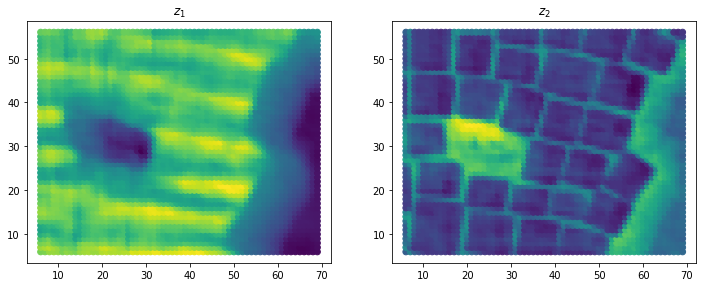

In [ ]:
# Map latent variables back onto the global image

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=z_loc[:, -2])
ax1.set_title('$z_1$')
ax1.set_aspect('equal')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=z_loc[:, -1])
ax2.set_title("$z_2$")
ax2.set_aspect('equal')

DKL prediction (input -> embedding -> GP -> mean & covar)

In [ ]:
mean, cov = model.dkl_predict(features_all)

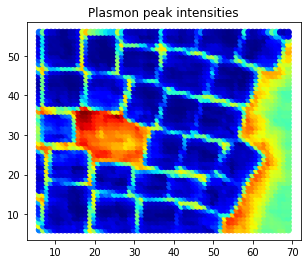

In [ ]:
_, ax = plt.subplots()
ax.scatter(indices_all[:, 1], indices_all[:, 0], c=mean.cpu(), cmap='jet')
ax.set_title('Plasmon peak intensities')
ax.set_aspect('equal')

Plot latent manifold using trained decoder of VAE:

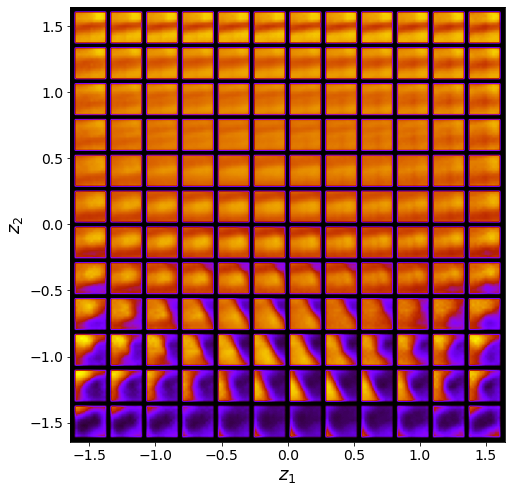

In [ ]:
loc_m = model.manifold2d(d=12)

Get DKL prediction for this latent grid used in manifold2d:

In [ ]:
z_grid, _ = generate_latent_grid(d=12)
mean_m, cov_m = model.get_mvn_posterior(z_grid)

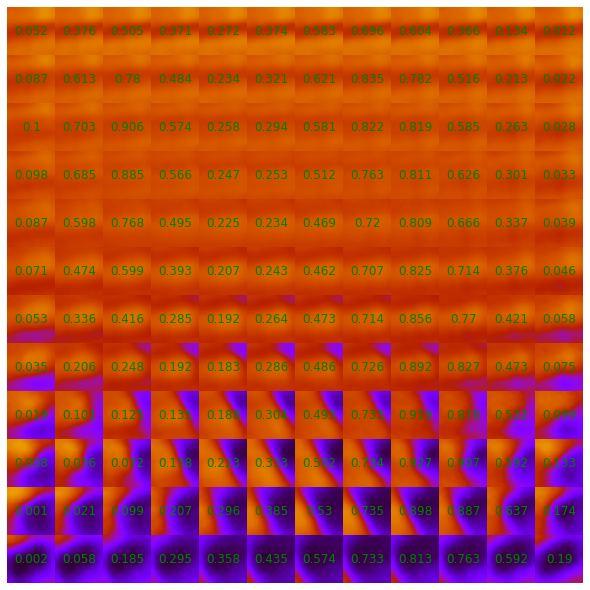

In [ ]:
images = loc_m.reshape(12*12, 12, 12)
values = mean_m.numpy() # cov_m.diagonal().numpy()

fig, axs = plt.subplots(12, 12, figsize=(8, 8))

for i in range(12):
    for j in range(12):
        axs[i, j].imshow(images[12 * i + j], cmap='gnuplot', vmin=0, vmax=1, interpolation='Gaussian')
        axs[i, j].text(0.5, 0.5, str(round(values[i*12 + j], 3)), fontsize=12, color='green',
                       ha='center', va='center', transform=axs[i, j].transAxes)
        axs[i, j].axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()


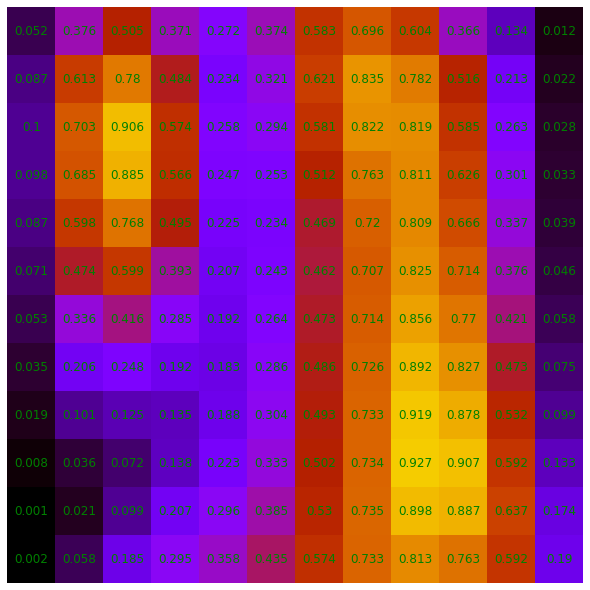

In [ ]:
fig, axs = plt.subplots(12, 12, figsize=(8, 8))

for i in range(12):
    for j in range(12):
        axs[i, j].imshow(np.ones((12, 12))*values[i*12 + j], cmap='gnuplot', vmin=0, vmax=1, interpolation='Gaussian')
        axs[i, j].text(0.5, 0.5, str(round(values[i*12 + j], 3)), fontsize=12, color='green',
                       ha='center', va='center', transform=axs[i, j].transAxes)
        axs[i, j].axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()
